In [1]:
import pydub
import wave
import scipy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch import nn
import tqdm
from scipy.io.wavfile import write

## 学習データ

In [4]:
#正解データ(wav_file)
#wav_file_HF = sorted(glob.glob('multi_16k_wav/*.wav'))
wav_file_HF = sorted(glob.glob("mp3_bitrate/orig/*.wav"))
read_path = '/home/corpus/VCTK-Corpus/wav48/p225/' 
HF_magnitude = []
HF_angle = []
#mtzk: glob の返り値はソートされてないので sorted が必要
for fname in tqdm.tqdm(wav_file_HF[:10000]):
    with wave.open(fname) as wave_file:
        length = wave_file.getnframes()
        fs = wave_file.getframerate()
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=128)
        mag = np.log(np.abs(Zxx) +10**(-20)).T
        HF_magnitude.append(mag)
        HF_angle.append(np.angle(Zxx).T)
        

100%|██████████| 10000/10000 [01:29<00:00, 112.31it/s]


In [6]:
#入力データ(mp3_file)
mp3_file_LF = sorted(glob.glob("mp3_bitrate/mp3/96k_*.wav"))
LF_magnitude = []
angle = []
amp = 2 * np.sqrt(2)
#mtzk: glob の返り値はソートされてないので sorted が必要
for fname in tqdm.tqdm(mp3_file_LF[:10000]):
    with wave.open(fname) as wave_file:
        length = wave_file.getnframes()
        fs = wave_file.getframerate()
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=128)
        mag = np.log(np.abs(Zxx) +10**(-20)).T
        #LF_magnitude.append(mag.tolist())
        LF_magnitude.append(mag)
        angle.append(np.angle(Zxx).T)


100%|██████████| 10000/10000 [01:46<00:00, 94.31it/s]


## データの前処理

In [7]:
import tqdm

#mtzk: HF と LF でフレーム数が違うことがあるので最初に短い方の長さを取得する
lengths = [min(len(hf), len(lf)) for hf, lf in zip(HF_magnitude, LF_magnitude)]

sp_size = len(LF_magnitude[0][0])
ur = 1
x_train = []
k = 0
time_size = 128
shift = 64
tdata_size = 9000
for j, data in tqdm.tqdm(enumerate(LF_magnitude[0: tdata_size])):
    i = 0
    #mtzk: HF/LF の短いほうに合わせる
    while i < lengths[j]-time_size:
    #while i < len(data)-time_size:
        #mtzk: np.array(data) してから切り出すとコピーが作られて遅いしメモリを食う．以下同様．
        #spg = np.array(data)[i:i + time_size, 0:sp_size//ur]
        spg = data[i:i + time_size]
        #mtzk: tolist しない．以下同様．
        #x_train.append(spg.tolist())
        x_train.append(spg)
        i += shift
    #mtzk: time_size よりフレーム数が少ないデータがある
    if lengths[j] >= time_size:
        #spg = np.array(data)[-time_size:, 0:sp_size//ur]
        spg = data[lengths[j]-time_size:lengths[j]]
        #x_train.append(spg.tolist()) 
        x_train.append(spg) 
    
y_train = []
for j, data in tqdm.tqdm(enumerate(HF_magnitude[0: tdata_size])):
    i = 0
    #mtzk: HF/LF の短いほうに合わせる
    while i < lengths[j]-time_size:
    #while i < len(data)-time_size:
        #spg = np.array(data)[i:i + time_size, sp_size//ur:]
        spg = data[i:i + time_size]
        #y_train.append(spg.tolist())
        y_train.append(spg)
        i += shift
    #mtzk: time_size よりフレーム数が少ないデータがある
    if lengths[j] >= time_size:
        #spg = np.array(data)[-time_size:, sp_size//ur:]
        spg = data[lengths[j]-time_size:lengths[j]]
        #y_train.append(spg.tolist()) 
        y_train.append(spg) 

x_valid = []
for jj, data in tqdm.tqdm(enumerate(LF_magnitude[tdata_size:])):
    j = tdata_size + jj
    i = 0
    while i < lengths[j]-time_size:
    #while i < len(data)-time_size:
        #spg = np.array(data)[i:i + time_size, 0:sp_size//ur]
        spg = data[i:i + time_size]
        #x_valid.append(spg.tolist())
        x_valid.append(spg)
        i += shift
    #mtzk: time_size よりフレーム数が少ないデータがある
    if lengths[j] >= time_size:
        #spg = np.array(data)[-time_size:, 0:sp_size//ur]
        spg = data[lengths[j]-time_size:lengths[j]]
        #x_valid.append(spg.tolist()) 
        x_valid.append(spg) 

y_valid = []
for jj, data in tqdm.tqdm(enumerate(HF_magnitude[tdata_size:])):
    j = tdata_size + jj
    i = 0
    while i < lengths[j]-time_size:
    #while i < len(data)-time_size:
        #spg = np.array(data)[i:i + time_size, sp_size//ur:]
        spg = data[i:i + time_size]
        #y_valid.append(spg.tolist())
        y_valid.append(spg)
        i += shift
    #mtzk: time_size よりフレーム数が少ないデータがある
    if lengths[j] >= time_size:
        #spg = np.array(data)[-time_size:, sp_size//ur:]
        spg = data[lengths[j]-time_size:lengths[j]]
        #y_valid.append(spg.tolist()) 
        y_valid.append(spg) 

9000it [00:00, 104589.73it/s]
9000it [00:00, 106453.52it/s]
1000it [00:00, 112695.58it/s]
1000it [00:00, 111435.05it/s]


## DataLoader

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # 入力
        self.t = Y # 出力

    def __len__(self):
        return len(self.t) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        #mtzk: 取り出すタイミングでひとつずつ torch.tensor にする
        #return self.X[index].to(device), self.t[index].to(device)
        return (torch.tensor(self.X[index]).to(device), 
                torch.tensor(self.t[index]).to(device))

In [10]:
train_dataset = AudioDataset(x_train, y_train)
valid_dataset = AudioDataset(x_valid, y_valid)

In [12]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## モデルの定義

In [13]:
ngf = 64
#output_size = len(LF_magnitude[0][0])
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv_1 = nn.Conv2d(1, ngf, 4, 2, 1, bias = False)
        self.bn_1 = nn.BatchNorm2d(ngf)
        self.conv_2 = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)
        self.bn_2 = nn.BatchNorm2d(ngf * 2)
        self.conv_3 = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.bn_3 = nn.BatchNorm2d(ngf * 4)
        self.conv_4 = nn.Conv2d(ngf * 4, ngf * 8, 4, 2, 1, bias=False)
        self.bn_4 = nn.BatchNorm2d(ngf * 8)
        self.convT_1 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.convT_2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.convT_3 = nn.ConvTranspose2d( ngf * 2, ngf , 4, 2, 1, bias=False)
        self.convT_4 = nn.ConvTranspose2d( ngf , 1, (4, 5), 2, 1, bias=False)
        self.bn_5 = nn.BatchNorm2d(1)
        #self.linear = nn.Linear(16512, 10112)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.flat = nn.Flatten()
 
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        conv1 = self.leakyrelu(self.bn_1(self.conv_1(x)))
        #print(conv1.shape)
        conv2 = self.leakyrelu(self.bn_2(self.conv_2(conv1)))
        #print(conv2.shape)
        conv3 = self.leakyrelu(self.bn_3(self.conv_3(conv2)))
        #print(conv3.shape)
        conv4 = self.leakyrelu(self.bn_4(self.conv_4(conv3)))
        
        convT1 = self.leakyrelu(self.bn_3(self.convT_1(conv4))) + conv3
        convT2 = self.leakyrelu(self.bn_2(self.convT_2(convT1))) + conv2
        #print(convT1.shape)
        convT3 = self.leakyrelu(self.bn_1(self.convT_3(convT2))) + conv1
        #print(convT2.shape)
        
        convT4 = self.leakyrelu(self.bn_5(self.convT_4(convT3))) + x
        #out = self.leakyrelu(self.linear(self.flat(convT4)))
        #out = torch.reshape(out, (out.shape[0], time_size, 79))
        
        out = convT4
        out = out.squeeze()
        return out

In [14]:

ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #self.linear_in = nn.Linear(256, )
        #入力128x78
        self.conv1 = nn.Conv2d(1, ndf, 4, 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(25, 1)
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        #32*64
        d1 = self.leakyrelu(self.conv1(x))
        #16*32
        d2 = self.leakyrelu(self.conv2(d1))
        #8*16
        d3 = self.leakyrelu(self.conv3(d2))
        d4 = self.leakyrelu(self.conv4(d3))
        d5 = self.leakyrelu(self.conv5(d4))
        #print(x.shape)
        x = self.flat(d5)
        x = x.squeeze()
        x = self.sigmoid(self.linear(x))
        return [d1, d2, d3, d4, d5] ,x

In [15]:

def train_and_valid(train_dataloader, valid_dataloader, model, loss_fn, optimizer, max_epoch):
    loss_train_list = []
    loss_valid_list = []
    for epoch in range(max_epoch):
        s = time.time()#計測開始
        #size = len(X_train)
        loss_train = 0
        total = 0
        for i, (X, y) in enumerate(train_dataloader):
            model.train()
            # Compute prediction error
            pred = model(X)
            #print(pred.shape)
            
            # loss = 0
            # for j in range(pred.shape[1]):
            #     seg_loss = loss_fn(pred[:, i:i+10], y[:, i:i+10])
            #     loss += (1/(j+1)) * seg_loss 

            #loss = loss_t + loss_m + loss_u
            #print(pred.shape, y[:,:, -79:].shape)
            
            loss = loss_fn(pred, y)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            total += len(X)
        loss_train = loss_train / total
        loss_train_list.append(loss_train)
        
        model.eval()
        loss_valid=0
        total = 0
        with torch.no_grad():
            for i, (X, y) in enumerate(valid_dataloader):
                pred = model(X)
                loss = loss_fn(pred, y)
                loss_valid += loss.item()
                total += len(X)
            loss_valid = loss_valid / total
            loss_valid_list.append(loss_valid)
        e = time.time()
        print('epoch:{3} time:{0} \n train_loss:{1} valid_loss:{2}'.format(e-s, loss_train, loss_valid, epoch))
    train_log = loss_train_list
    valid_log = loss_valid_list
    return train_log, valid_log

In [16]:
# カスタムの重み初期化用関数。netGとnetDで呼び出される
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:

device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
batch_size = 256
#in_size = int(sp_size//ur)
#out_size = int(sp_size - sp_size//ur)

netG = Generator()
netG.apply(weights_init)
netG.to(device)

print(netG)

Generator(
  (conv_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT_1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT_3): ConvTranspose2d(128, 64, kernel_size=(4, 4), 

In [18]:
# 識別器を作成する
netD = Discriminator()

# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netD.apply(weights_init)

netD.to(device)

# モデルをprint出力する
print(netD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (sigmoid): Sigmoid()
  (linear): Linear(in_features=25, out_features=1, bias=True)
)


In [19]:
max_epoch = 1
optimizer = torch.optim.Adam(netG.parameters(), lr=1e-5)
optimizer.zero_grad()
loss_fn = nn.MSELoss()

## Generatorのみを学習

In [20]:
import time
train_log, valid_log = train_and_valid(train_dataloader, valid_dataloader, netG, loss_fn, optimizer, max_epoch)

epoch:0 time:184.99235033988953 
 train_loss:0.004426295440128722 valid_loss:0.009991007023464416


In [20]:
torch.cuda.is_available()

True

In [21]:
class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input = torch.where(torch.isnan(input), torch.zeros_like(input), input)
        input = torch.where(torch.isinf(input), torch.zeros_like(input), input)
        input = torch.where(input>1, torch.ones_like(input), input)  # 1を超える場合には1にする

        target = target.float()

        return self.bce(input, target)

In [22]:
def pred_show_spe(fname):
    
    amp = 2 * np.sqrt(2)
    pred_spectral=[]
    with wave.open(fname) as wave_file:
        length = wave_file.getnframes()
        fs = wave_file.getframerate()
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=128)
        data = np.log(np.abs(Zxx) +10**(-10)).T
        angle_data = np.angle(Zxx).T
    i = 0
    in_rate = 0.0
    pred_sp = []
    while i <= len(data)-time_size:
        input_sp = torch.tensor(data)[i:i+time_size]
        input_sp = input_sp.unsqueeze(0)
        output_sp = netG(input_sp.to(device))
        input_sp = input_sp.squeeze().tolist()
        output_sp = output_sp.squeeze().tolist()
        for j in range(time_size):
            #print(len(input[j])) 
            sp = input_sp[j][:int(in_rate*len(input_sp[j]))] + output_sp[j][int(in_rate*len(input_sp[j])):]
            pred_sp.append(sp)
        i += time_size
        #print(i)
    input_sp = torch.tensor(data)[-time_size:]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    #print(input_sp.shape)
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    #print(int(in_rate*len(input_sp[j])))
    for i in range(len(data)%time_size):
        sp = input_sp[time_size - len(data)%time_size + i][:int(in_rate*len(input_sp[j]))] + output_sp[time_size - len(data)%time_size + i][int(in_rate*len(input_sp[j])):]
        pred_sp.append(sp)
    num_pred = np.array(pred_sp)
    magnitude_spectrogram = np.exp(num_pred.T) 
    spectral_dnn= get_spectral(HF_angle[number].T, magnitude_spectrogram)
    spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
    _, wav_xrec = signal.istft(spectral_dnn, 48000, nperseg=256, noverlap=64)
    wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする
    plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)
    plt.colorbar()
    #plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [23]:
def get_spectral(angle_a, abs_a):
    return abs_a * (np.cos(angle_a) + 1j * np.sin(angle_a))

In [24]:
def cal_LSD(x, y):
    x = np.log(x**2 + 10 ** (-10))
    y = np.log(y**2 + 10 ** (-10))
    return (1/x.shape[0])*(((1/x.shape[1])*((x-y)**2).sum(axis=1)) ** 0.5).sum()

In [25]:
num_epochs = 6
batch_size = 256
# BCELoss関数の初期化
criterion = BCELoss()
mse = nn.MSELoss()
l1 = nn.L1Loss()
#criterion_G = nn.BCELoss() + nn.MSELoss()
lr = 0.0002
lrG = 10**(-5)
lrD = 4.0 * 10**(-5)
beta1 = 0.5
beta2 = 0.5
# GとDの両方にオプティマイザ：Adamを設定する
optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(beta2, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

Starting Training Loop...
[1/6][0/726]	Loss_D: 1.3866	Loss_G: 0.7050	D(x): 0.4959	D(G(z)): 0.4960 / 0.4941
mse_loss_under :2.5486581325531006


<ipython-input-22-f2b6697084c1>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(magnitude_spectrogram), vmin=0, vmax=amp)


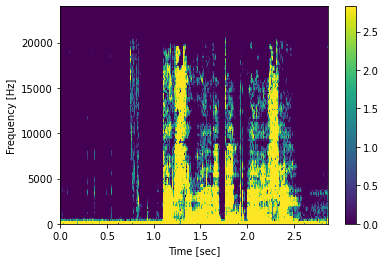

[1/6][200/726]	Loss_D: 1.2615	Loss_G: 0.7527	D(x): 0.5220	D(G(z)): 0.4438 / 0.4791
mse_loss_under :0.5699743628501892


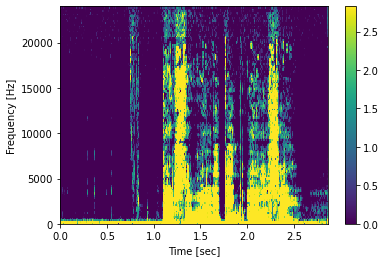

[1/6][400/726]	Loss_D: 1.2361	Loss_G: 0.7556	D(x): 0.5263	D(G(z)): 0.4293 / 0.4821
mse_loss_under :0.5426139831542969


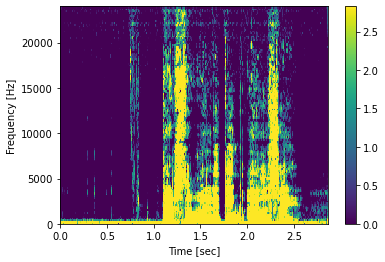

[1/6][600/726]	Loss_D: 1.2431	Loss_G: 0.7654	D(x): 0.5308	D(G(z)): 0.4277 / 0.4818
mse_loss_under :0.5201256275177002


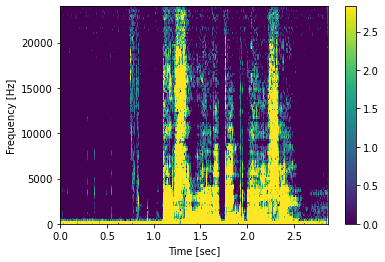

epoch: 1 time: 657.6803064346313
[2/6][0/726]	Loss_D: 1.2528	Loss_G: 0.7619	D(x): 0.5132	D(G(z)): 0.4213 / 0.4800
mse_loss_under :0.5173203349113464


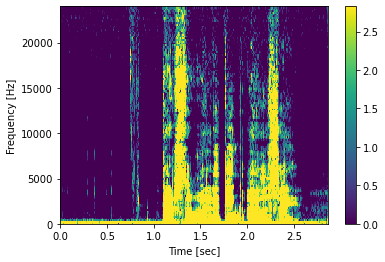

[2/6][200/726]	Loss_D: 1.2327	Loss_G: 0.8384	D(x): 0.5689	D(G(z)): 0.4653 / 0.4476
mse_loss_under :0.4912607669830322


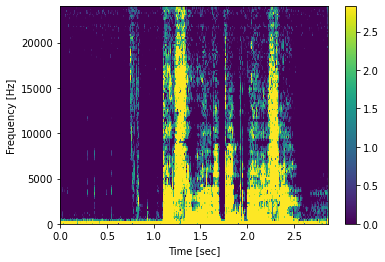

[2/6][400/726]	Loss_D: 1.2066	Loss_G: 0.8210	D(x): 0.5431	D(G(z)): 0.4178 / 0.4582
mse_loss_under :0.5085791349411011


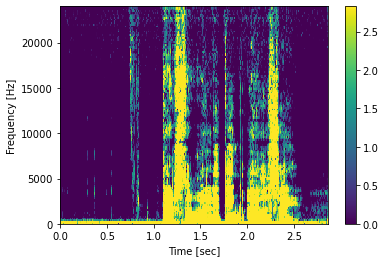

[2/6][600/726]	Loss_D: 1.2159	Loss_G: 0.8437	D(x): 0.5623	D(G(z)): 0.4490 / 0.4432
mse_loss_under :0.4865981936454773


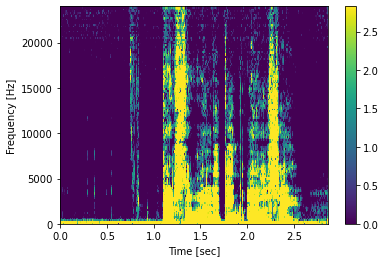

epoch: 2 time: 669.8589217662811
[3/6][0/726]	Loss_D: 1.2144	Loss_G: 0.8411	D(x): 0.5766	D(G(z)): 0.4575 / 0.4457
mse_loss_under :0.4947587251663208


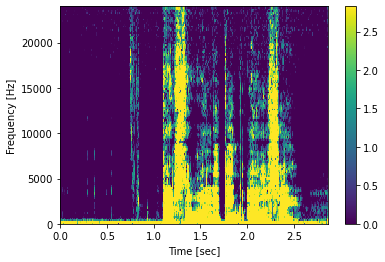

[3/6][200/726]	Loss_D: 1.1718	Loss_G: 0.8644	D(x): 0.5683	D(G(z)): 0.4194 / 0.4393
mse_loss_under :0.4703005850315094


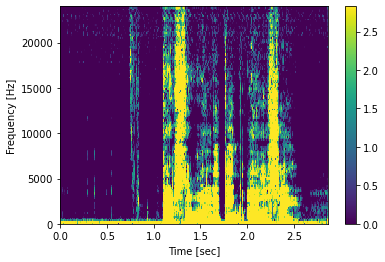

[3/6][400/726]	Loss_D: 1.2156	Loss_G: 1.0253	D(x): 0.6108	D(G(z)): 0.4882 / 0.3903
mse_loss_under :0.4796190857887268


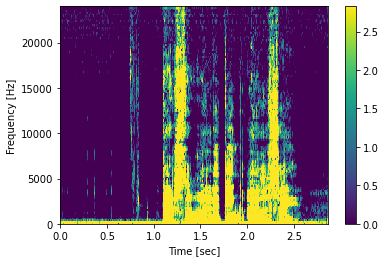

[3/6][600/726]	Loss_D: 1.2365	Loss_G: 1.0196	D(x): 0.6624	D(G(z)): 0.5310 / 0.3844
mse_loss_under :0.46659210324287415


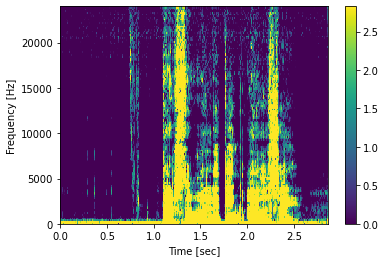

epoch: 3 time: 670.2232010364532
[4/6][0/726]	Loss_D: 1.2473	Loss_G: 0.7304	D(x): 0.5383	D(G(z)): 0.4167 / 0.4977
mse_loss_under :0.4860226511955261


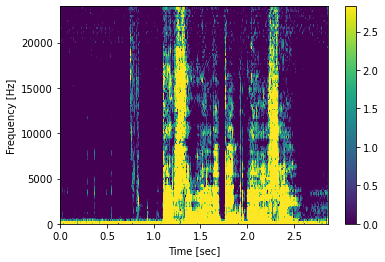

[4/6][200/726]	Loss_D: 1.2104	Loss_G: 1.0422	D(x): 0.6189	D(G(z)): 0.4835 / 0.3785
mse_loss_under :0.4782513678073883


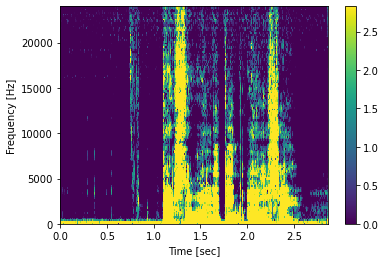

[4/6][400/726]	Loss_D: 1.1268	Loss_G: 0.8556	D(x): 0.5765	D(G(z)): 0.4015 / 0.4469
mse_loss_under :0.4678099751472473


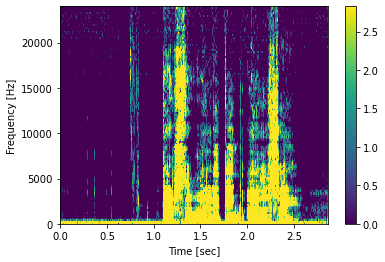

[4/6][600/726]	Loss_D: 1.2143	Loss_G: 1.2403	D(x): 0.6928	D(G(z)): 0.5348 / 0.3183
mse_loss_under :0.4691464900970459


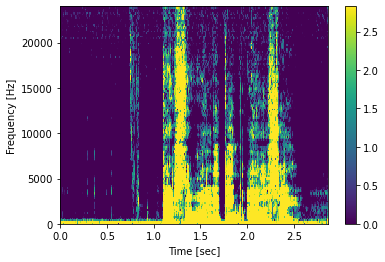

epoch: 4 time: 673.6235942840576
[5/6][0/726]	Loss_D: 1.1194	Loss_G: 0.8622	D(x): 0.5318	D(G(z)): 0.3286 / 0.4458
mse_loss_under :0.4735684096813202


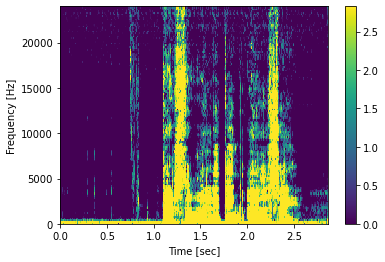

[5/6][200/726]	Loss_D: 1.1336	Loss_G: 1.1094	D(x): 0.6521	D(G(z)): 0.4683 / 0.3569
mse_loss_under :0.44861483573913574


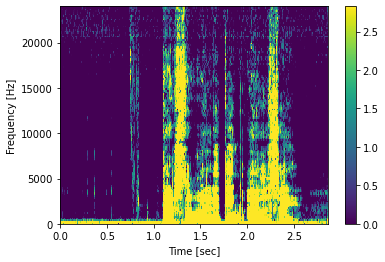

[5/6][400/726]	Loss_D: 1.0877	Loss_G: 0.8719	D(x): 0.5777	D(G(z)): 0.3672 / 0.4460
mse_loss_under :0.4691372513771057


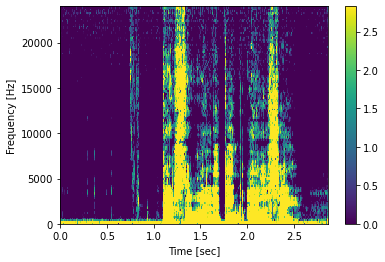

[5/6][600/726]	Loss_D: 1.1504	Loss_G: 1.2202	D(x): 0.6803	D(G(z)): 0.4982 / 0.3245
mse_loss_under :0.4593324661254883


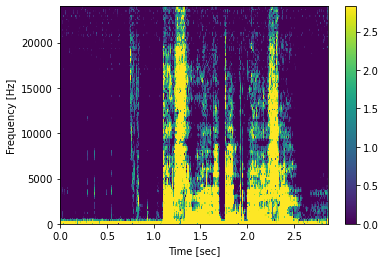

epoch: 5 time: 673.5443398952484
[6/6][0/726]	Loss_D: 1.0851	Loss_G: 1.1870	D(x): 0.7142	D(G(z)): 0.4924 / 0.3326
mse_loss_under :0.46431997418403625


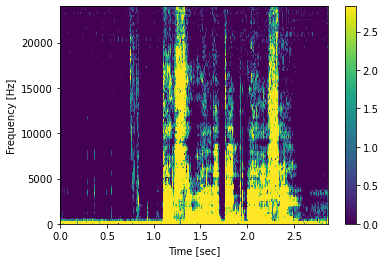

[6/6][200/726]	Loss_D: 1.1178	Loss_G: 0.9323	D(x): 0.5741	D(G(z)): 0.3724 / 0.4265
mse_loss_under :0.44251126050949097


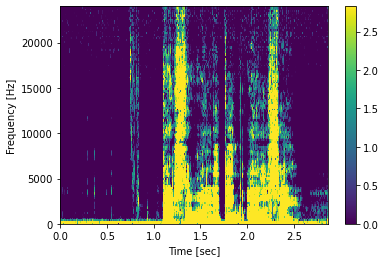

[6/6][400/726]	Loss_D: 1.1462	Loss_G: 1.0008	D(x): 0.6394	D(G(z)): 0.4552 / 0.3965
mse_loss_under :0.46152830123901367


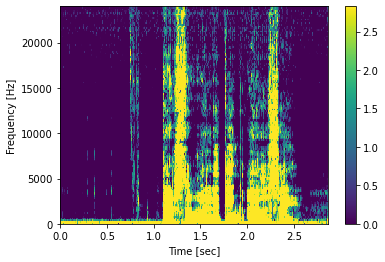

[6/6][600/726]	Loss_D: 1.1572	Loss_G: 1.1575	D(x): 0.6963	D(G(z)): 0.5053 / 0.3494
mse_loss_under :0.48004835844039917


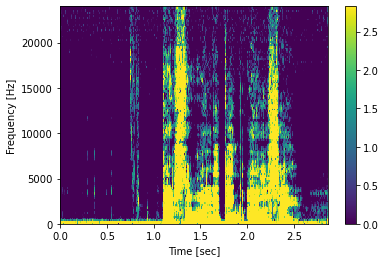

epoch: 6 time: 673.7561810016632


In [26]:
import time
import random
# 訓練のループ

# 訓練の進捗状況を把握するためのリスト

G_losses = []
D_losses = []
iters = 0
loss_rate = 1
print("Starting Training Loop...")
# 各エポックについて
for epoch in range(num_epochs):
    s = time.time()#計測開始
    # dataloader内の各バッチについて
    for i, (X, y) in enumerate(train_dataloader):
        #y = y[:,:, -79:]
        ############################
        #  (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        ## 本物画像のバッチを使った訓練
        netD.zero_grad()
        # バッチの形式をランタイムに合わせる
        #real_cpu = y #y_train
        label = torch.ones((X.shape[0], 1)).to(device)
        #torch.full((b_size,), real_label, dtype=torch.float, device=device) #label = 1 np.ones(batch_size)
        # 本物画像のバッチをDに順伝播させる
        #print(y.shape)
        _, output = netD(y) #0か1を予測
        # 全ての本物画像のバッチの損失を計算する
        errD_real = criterion(output, label) #答え合わせ
        # 逆伝播で勾配を計算する
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        
        # Gを使って、偽画像のバッチを生成
        fake = netG(X) #低解像度を入力
        label = torch.zeros((X.shape[0], 1)).to(device)
        # Dを使って、全ての偽画像を分類
        _, output = netD(fake) #0か1
        
        # 全ての偽画像に対するDの損失を計算
        errD_fake = criterion(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        
        
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.ones((X.shape[0], 1)).to(device) #Dが間違えたら損失が減るように
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        fake_features, output = netD(fake)
        
        real_features, _ = netD(y)
        feature_loss = 0
        for n in range(len(fake_features)):
            feature_loss += l1(fake_features[n], real_features[n])
        # この出力に対するGの損失をもう一度計算
        bce_loss = criterion(output, label)
        mse_loss = mse(fake, y)
        seg_mse = 0
        for j in range(len(fake[0])//10):
            seg_loss = mse(fake[:,j:j + 10], y[:,j:j + 10])
            seg_mse += (1/(j+1)) * seg_loss
        HF_mse_loss = mse(fake[:,110:], y[:, 110:])
        #errG = (1/(epoch+1)) * bce_loss + feature_loss *(1/len(fake_features))+under_mse_loss * 0.25 * (epoch+1)
        #+ (0.3 * epoch) * mse_loss
        errG = 0.2 * bce_loss + feature_loss * (1/len(fake_features)) + mse_loss * (0.2 * epoch) + HF_mse_loss * (1 / (epoch + 1)) + seg_mse * (1/(len(fake[0])//10)) * (epoch+1)
        
        # Gの勾配を計算
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     errD.item(), bce_loss.item(), D_x, D_G_z1, D_G_z2))
            print('mse_loss_under :{0}'.format(mse(fake[:,:20], y[:,:20])))
            #print('lsd :{0}'.format(cal_lsd(fake, y).mean())
            #print(feature_loss, bce_loss, mse_loss)
            #number = random.randint(tdata_size, len(LF_magnitude))
            #print('data_number: {0}'.format(number))
            number = 9701
            pred_show_spe(mp3_file_LF[number])
        # あとでプロットするために損失を保存
        G_losses.append(bce_loss.item())
        D_losses.append(errD.item())
        iters += 1
    if errD.item() < bce_loss.item():
        loss_rate *= 2
    e = time.time()#計測終了
    print('epoch: {1} time: {0}'.format(e-s, epoch+1))

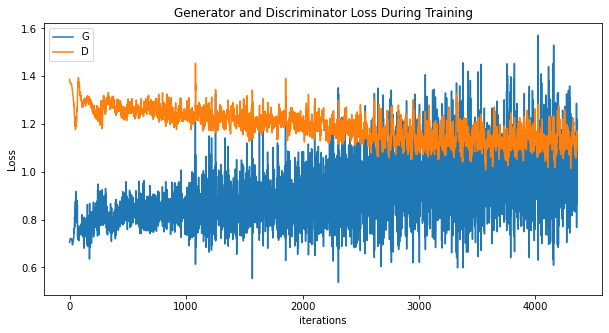

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [62]:
netG.eval()
amp = 2 * np.sqrt(2)
pred_spectral=[]
number = 9701
data = LF_magnitude[number]
i = 0
pred_sp = []
while i <= len(data)-time_size:
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size):
        sp = output_sp[j]
        pred_sp.append(sp)
    i += time_size
    #print(i)
input_sp = torch.tensor(data)[-time_size:]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
output_sp = output_sp.squeeze().tolist()
for i in range(len(data)%time_size):
    sp = output_sp[time_size - len(data)%time_size + i]
    pred_sp.append(sp)
num_pred = np.array(pred_sp)
magnitude_spectrogram = np.exp(num_pred.T) 
spectral_dnn= get_spectral(angle[number].T, magnitude_spectrogram)
spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
#spectral_dnn = np.where(np.abs(spectral_dnn) <= np.max(np.exp(data)), spectral_dnn, np.max(data))
#print(np.max(np.exp(data)), np.max(np.abs(spectral_dnn)))
_, wav_xrec = signal.istft(spectral_dnn, 48000, nperseg=256, noverlap=64)
wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする

In [28]:
netG.eval()
amp = 2 * np.sqrt(2)
pred_spectral=[]
number = 9701
data = LF_magnitude[number]
i = 0
in_rate = ((129-95)/129)
pred_sp = []
while i <= len(data)-time_size:
    input_sp = torch.tensor(data)[i:i+time_size]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size):
        #print(len(input[j])) 
        sp = input_sp[j][:int(in_rate*len(input_sp[j]))] + output_sp[j][int(in_rate*len(input_sp[j])):] 
        pred_sp.append(sp)
    i += time_size
    #print(i)
input_sp = torch.tensor(data)[-time_size:]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
print(input_sp.shape)
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
print(int(in_rate*len(input_sp[j])))
for i in range(len(data)%time_size):
    sp =  input_sp[time_size - len(data)%time_size + i][:int(in_rate*len(input_sp[j]))] + output_sp[time_size - len(data)%time_size + i][int(in_rate*len(input_sp[j])):] 
    pred_sp.append(sp)
num_pred = np.array(pred_sp)
magnitude_spectrogram = np.exp(num_pred.T) 
spectral_dnn= get_spectral(angle[number].T, magnitude_spectrogram)
spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
print(np.max(np.exp(data)), np.max(np.abs(spectral_dnn)))
#spectral_dnn = np.where(np.abs(spectral_dnn) <= np.max(np.exp(data)), spectral_dnn, 0)
#print(np.max(np.exp(data)), np.max(np.abs(spectral_dnn)))
_, wav_xrec = signal.istft(spectral_dnn, 48000, nperseg=256, noverlap=128)
wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする

torch.Size([1, 128, 129])
34
4181.302 4181.302038414084


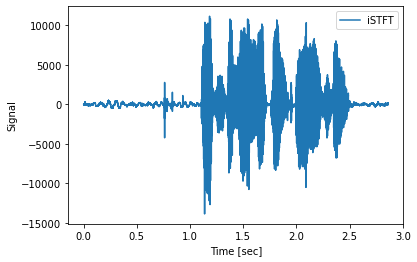

In [30]:
length = len(wav_xrec)
fs = 48000
time = np.arange(length) / float(fs)
plt.plot(time, wav_xrec[:length])
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['iSTFT'])

plt.show()

In [31]:
from scipy.io.wavfile import write
write("96k_mp3.wav", 48000, wav_xrec)
import IPython.display
IPython.display.Audio("96k_mp3.wav")

In [32]:
import IPython.display
IPython.display.Audio(wav_file_HF[number])

In [33]:
import IPython.display
IPython.display.Audio(mp3_file_LF[number])

In [34]:
def stft(read_path):
    wave_file = wave.open(read_path, "r")

    amp = 2 * np.sqrt(2)
    length = wave_file.getnframes()
    fs = wave_file.getframerate()
    time = np.arange(length) / float(fs)
    x = wave_file.readframes(wave_file.getnframes())
    wav_x = np.frombuffer(x, dtype= "int16")

    f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=128)
    print('フレームレート:{0}'.format(fs))
    plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
    plt.colorbar()
    #plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

フレームレート:48000


<ipython-input-34-8ae89a4a915a>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


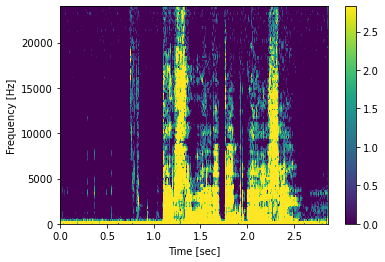

In [35]:
stft("96k_mp3.wav")

フレームレート:48000


<ipython-input-34-8ae89a4a915a>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


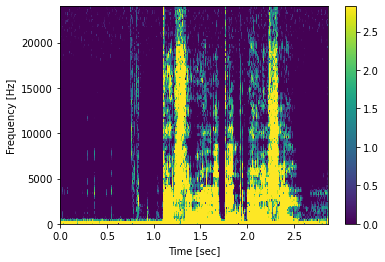

In [36]:
stft(wav_file_HF[number])

フレームレート:48000


<ipython-input-34-8ae89a4a915a>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


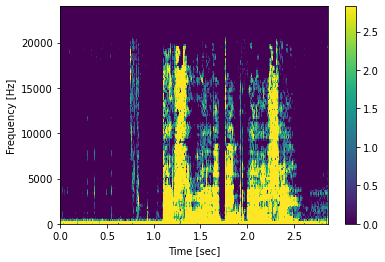

In [37]:
stft(mp3_file_LF[number])

In [38]:
model_path = '96k_shift128_gpu.pth'
torch.save(netG.state_dict(), model_path)

In [20]:
model_path = '96k_128shift_gpu.pth'
netG.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
netG.eval()

Generator(
  (conv_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT_1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convT_3): ConvTranspose2d(128, 64, kernel_size=(4, 4), 

In [215]:
model_path = '96k_cpu.pth'
netG.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>